## Basic Classification

<br>

- 패션 MNIST 데이터 셋 이용.
    - 10개의 범주, 70,000개의 흑백 이미지로 구성.
    - 이미지는 $28*28$ 픽셀. 각 픽셀은 옷 품목을 의미.
- 운동화, 셔츠 등의 옷을 분류.

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data loading
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
test_labels

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

    이미지는 28*28 크기의 ndarray.
    각 픽셀값은 0~255 사이.
    레이블은 0~9 까지의 정수 배열. 옷의 클래스를 의미.
    
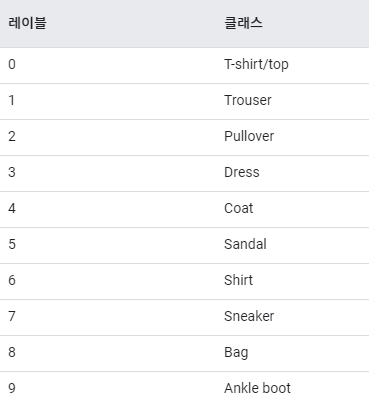

In [8]:
# 이미지 출력에 사용하기 위해 별도의 변수를 만들어 저장하자.
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Preprocessing

<br>

- 이미지들의 픽셀 범위 값이 0~255 사이.

C:\Users\skdbs\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['gulim'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


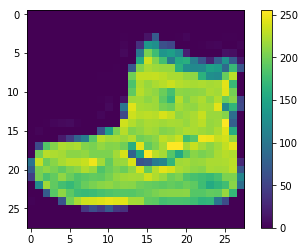

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [12]:
# 값의 범위를 0~1 사이로 스케일링 하자.
# StandardScaler는 못쓰나?
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler()
minMaxScaler.fit(train_images)
train_images_scaled = minMaxScaler.transform(train_images)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

    이렇겐 안되나보구나 ㅎㅎ;;

In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

    훈련 데이터의 처음 10개 이미지와 클래스 이름을 출력해보자.

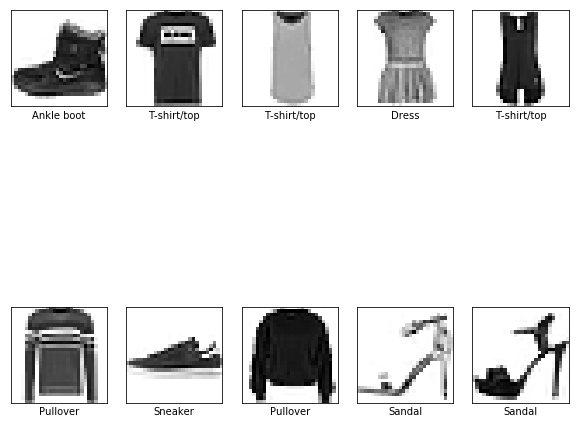

In [16]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i+1) # 2행 5열 subplot.
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### Model Building

<br>

- 층을 먼저 구성.
- 층은 입력된 데이터에서 특성을 추출.
- 대부분의 딥러닝은 **간단한 층을 여러개 연결**해서 구성하게 된다.

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'), # 128개의 unit, 각 unit의 활성함수는 relu.
    keras.layers.Dense(10, activation='softmax') # 10개의 출력 unit, 다중 분류를 위한 softmax
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


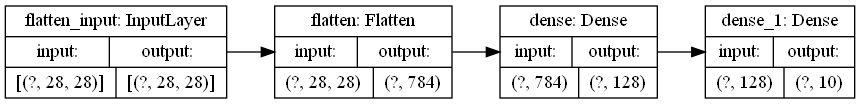

In [19]:
keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

- **첫번째 층 Flatten** 
    - 2차원 배열인 $28*28$크기의 이미지 포맷을 $28*28=784$픽셀의 1차원 배열로 변환.
    - **픽셀의 행을 펼쳐서 1열로 늘린 셈.** 
    - 가중치는 없고, **오로지 데이터를 변환하기만 한다.**
- **두개의 Dense 층**
    - 밀집 연결(densely-connected) or **완전 연결(fully-connected)**층 이라고 함
        - 첫번째 Dense층은 **128개의 노드(unit)**를 가짐. 출력수 == 유닛 수
        - 두번째 Dense층은 **10개의 노드**를 가짐. softmax 층.
            - 10개의 확률을 반환, 반환된 값의 전체 합은 1.
            - **각 노드는 현재 이미지가 10개의 클래스 중 하나에 속할 확률을 출력.**

### Model Compiling

<br>

- 모델을 훈련하기 전, 훈련시킬 방법을 정의하는 단계.
    - **Loss Function** : 훈련하는 동안 **모델의 오차를 측정**. 학습이 올바른 방향으로 향하도록 **이 함수값을 최소화 해야 함.**
    - **Optimizer** : 데이터와 손실함수를 바탕으로 **모델의 파라미터 업데이트 방법을 결정.**
    - **Metrics** : **훈련 단계와 테스트 단계를 모니터링** 하기 위해 사용. 이번 예시는 **올바른 분류 비율을 측정하기 위해 정확도(accuracy)를 사용**함.
- 이 복잡한 컴파일이 단 한줄로 끝난다. 어메이징.

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Model Training

<br>

1. 훈련 데이터를 모델에 넘긴다. 
    - 여기선 train_images와 train_labels 배열.
2. 넘기게 되면 모델이 알아서 이미지와 레이블을 매핑하는 방법을 학습한다.
3. 테스트 데이터에 대한 모델의 예측을 만든다.
    - 즉, test_images가 test_labels의 레이블과 맞는지 확인.

<br>

- 이 복잡한 과정도 마찬가지로 .fit()으로 끝난다.

In [21]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4980 - accuracy: 0.8239
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3744 - accuracy: 0.8651: 0s
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3371 - accuracy: 0.8777
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3129 - accuracy: 0.8856
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2943 - accuracy: 0.8917


    각 에포크마다 정확도가 점점 증가하는걸 볼 수 있음. loss도 줄어들고 있다.

### Evaluate Accuracy

<br>

- 테스트 데이터에서의 모델 성능을 측정한다.
- 이도 마찬가지로 .evaluate()로 끝난다.

In [24]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(f'\n 테스트 정확도는 {test_acc} % 이다.')

313/313 [==============================] - 0s 1ms/step - loss: 0.3413 - accuracy: 0.8767

 테스트 정확도는 0.8766999840736389 % 이다.


- 테스트 데이터에 대한 정확도가 훈련 데이터에 대한 정확도보다 조금 낮게 나온다. Why?
- Overfitting 때문. 
    - 훈련 데이터에 너무 최적화 되었기에, 새로운 데이터에 대해선 성능이 조금 떨어지게 나오는 현상.
    - How? 여태 공부해왔던거를 적용할 수 있음.
        1. **가중치 정규화** - L1규제(Lasso, 가중치의 절대값에 비례하는 패널티(L1 norm) 부여), L2규제(Ridge, 가중치의 제곱값에 비례하는 패널티(L2 norm의 제곱) 부여)
            - 근데 정규화에서 보통 L2규제를 많이 씀. 왜?
                - L1 규제는 절대값이라는 특성상 일부 가중치 파라미터를 0으로 만들어버림.
        2. **유닛 수 감소시키기** or **연결정도 약화**
        3. **조기 종료**

    과적합, 과소적합 예시에서 좀더 상세히 다루자.

### Make Predictions

<br>

- 훈련시킨 모델을 통해 예측을 해볼 수도있다.

In [26]:
predictions = model.predict(test_images)
predictions

array([[6.98786971e-05, 2.07328480e-06, 2.05951756e-06, ...,
        9.84251201e-02, 1.71120555e-05, 8.83141637e-01],
       [2.00710747e-05, 3.43881865e-08, 9.97658491e-01, ...,
        3.92753104e-12, 4.39594894e-09, 6.13740168e-15],
       [1.53135495e-08, 1.00000000e+00, 1.10501185e-10, ...,
        8.58514473e-20, 8.34625164e-12, 1.00808966e-14],
       ...,
       [2.99701211e-03, 3.26543358e-07, 5.11544931e-04, ...,
        7.15321704e-08, 9.96221781e-01, 5.28194655e-10],
       [2.05921840e-08, 9.99983311e-01, 3.36072237e-09, ...,
        1.58292406e-13, 2.23700791e-09, 1.30025402e-09],
       [2.23133666e-05, 4.94260973e-07, 3.87287910e-05, ...,
        8.26340634e-03, 5.77233383e-04, 1.87645157e-04]], dtype=float32)

    배열의 각 값은 10개의 옷 품목에 대응되는 모델의 신뢰도(confidence)를 의미.
    즉, 각 테스트 이미지가 어떤 label에 해당하는지 그 확률을 나타내고 있음.
    
    가장 높은 신뢰도를 가진 레이블을 찾아보자.

In [27]:
np.argmax(predictions[0])

9

    모델은 이 이미지가 앵클 부츠라고 확신하고 있음. 
    테스트 레이블로 진짜 맞는지 확인해보자.

In [28]:
test_labels[0]

9

    10개의 클래스에 대한 예측을 모두 그래프로 표현해보자.

In [34]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    
    # 예측한 라벨과 실제 라벨이 같은지?
    # 맞으면 파란색, 틀리면 빨간색.
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    # 해당 정보들을 가지고 라벨링.
    plt.xlabel('prediction : {} {:2.0f}% \n (true label : {})'.format(class_names[predicted_label],
                                         100*np.max(predictions_array), # 최대값 == 예측한 값
                                         class_names[true_label]), color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0, 1]) # y축 범위 설정
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

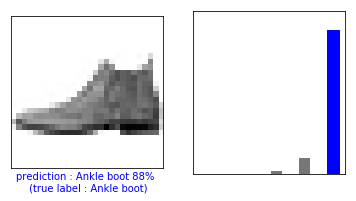

In [35]:
# 0번째 원소에 대해 이미지, 예측, 신뢰도 점수를 확인해보자.
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)
plt.show()

    응용해서 몇 개의 이미지 예측을 판단해보자.

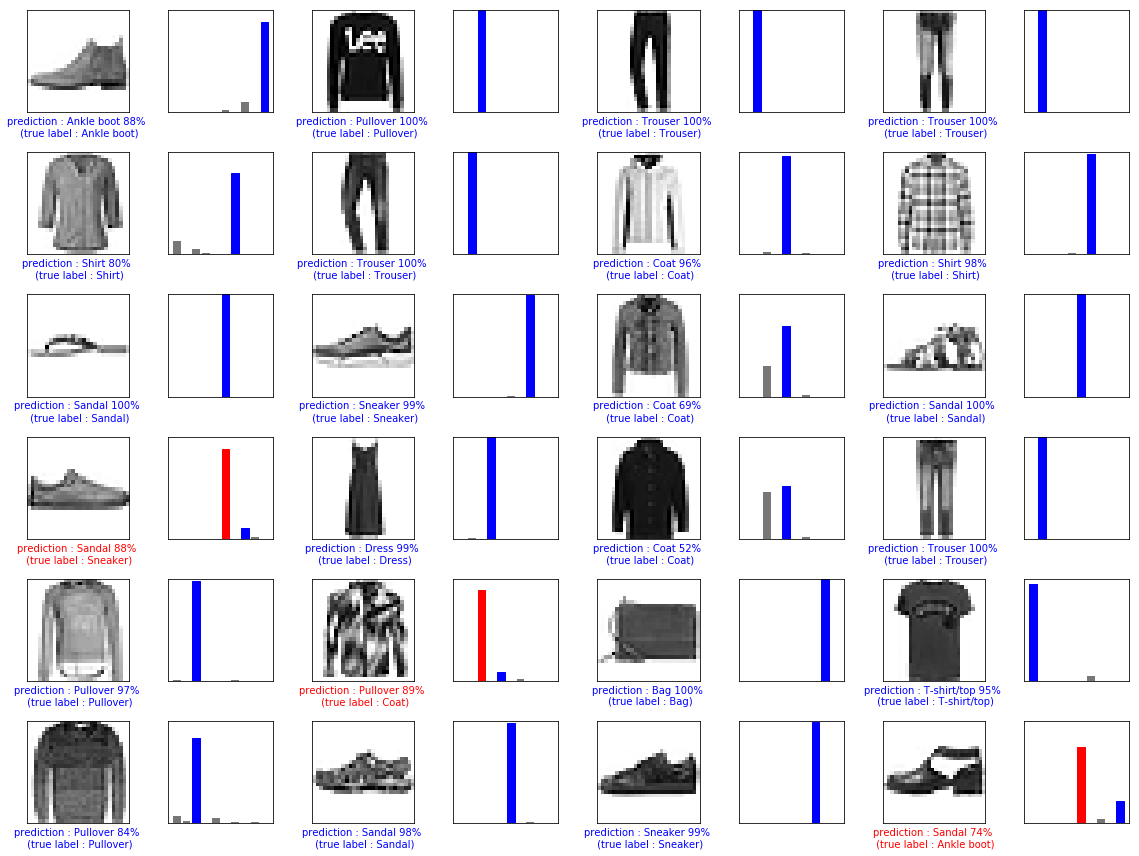

In [37]:
num_rows = 6
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.tight_layout()
plt.show()